## pipeline

In [2]:
from pici_predictor.utilities import discover_pici

data_dir = "../dataset/demonstration_samples/GCF_000175755.1"
results_dir = "../results/demonstration/GCF_000175755.1"
model_function_path = "../models/best_configs"
model_pici_path = "../models/pici_classifier_model.json"
results = discover_pici(data_dir, results_dir, model_function_path, model_pici_path)
results["predicted_class_name"].value_counts()

Loading sequences: 100%|██████████| 5095/5095 [00:00<00:00, 632566.05it/s]


Features saved to ../dataset/demonstration_samples/GCF_000175755.1/features.pa
function
no_hit                                              2406
moron_auxiliary_metabolic_gene_and_host_takeover     659
unknown_function                                     484
dna_rna_and_nucleotide_metabolism                    454
other                                                228
tail                                                 219
transcription_regulation                             190
lysis                                                145
head_and_packaging                                   137
integration_and_excision                             109
connector                                             64
Name: count, dtype: int64


predicted_class_name
none    10127
PICI       17
Name: count, dtype: int64

## protein -> features

In [ ]:
# from pici_predictor.utilities import feature_generation

# feature_df = feature_generation(fasta_dir, out_dir)

## features -> functional categories

In [20]:
import pandas as pd
import joblib
import numpy as np
import xgboost as xgb
from pici_predictor.phrog_function import (
    function_names_formatted,
    function_name_formatted_to_num,
    thresholds_0_5,
    mu_neg_dict,
    sigma_neg_dict,
)

function_list = [name for name in function_names_formatted if name != "no_hit"]


def predict_function(feature_df, out_dir):
    predicted_probs = pd.DataFrame({"id": feature_df["id"]})

    for function_name in function_list:
        model_bundle = joblib.load(
            f"../models/best_configs/{function_name}_predictor.joblib"
        )
        model = model_bundle["model"]
        scaler = model_bundle.get("scaler", None)
        feature_cols = model_bundle["feature_cols"]

        # Handle special case for unknown_function
        # if function_name == "unknown_function":
        #     features = feature_df.drop(
        #         columns=[
        #             col
        #             for col in feature_df.columns
        #             if "DIPEP" in col or "TRIPEP" in col
        #         ]
        #     )[feature_cols]
        # else:
        #     features = feature_df[feature_cols]
        features = feature_df[feature_cols]

        # Check for missing columns
        # missing = set(feature_cols) - set(feature_df.columns)
        # if len(missing) > 0:
        #     print("Number of missing columns:", len(missing))
        #     print(function_name)
        #     print(f"len(feature_df.columns): {len(feature_df.columns)}")
        #     print(f"len(feature_cols): {len(feature_cols)}")
        #     continue

        # Apply scaler if present
        if scaler is not None:
            features = scaler.transform(features.values)
        else:
            features = features.values

        probs = model.predict_proba(features)[:, 1]
        predicted_probs[function_name] = probs

    predicted_probs.to_csv(out_dir, index=False)
    return predicted_probs

In [21]:
feature_df = pd.read_parquet(
    "../dataset/demonstration_samples/GCF_000175755.1/features.pa"
)
out_dir = "../results/demonstration/GCF_000175755.1/predicted_function_prob.csv"
predicted_probs = predict_function(feature_df, out_dir)
predicted_probs.describe()

,lysis,tail,connector,dna_rna_and_nucleotide_metabolism,head_and_packaging,other,transcription_regulation,moron_auxiliary_metabolic_gene_and_host_takeover,unknown_function,integration_and_excision
count,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5.095000e+03,5095.000000,5.095000e+03
mean,4.197149e-02,5.267216e-02,1.790590e-02,1.272131e-01,4.170030e-02,6.548048e-02,4.546663e-02,1.758945e-01,0.162073,3.772519e-02
std,1.450015e-01,1.859927e-01,9.747143e-02,2.488380e-01,1.463544e-01,1.779522e-01,1.670590e-01,3.350859e-01,0.255854,1.399319e-01
min,3.316258e-07,5.845677e-09,1.925288e-10,1.315626e-08,2.414984e-08,3.490532e-07,1.009539e-10,3.937497e-07,0.000041,3.652946e-07
25%,1.216153e-04,3.945677e-05,2.262310e-06,6.671088e-04,7.667561e-05,4.222996e-04,1.084801e-06,4.957813e-04,0.008754,1.505424e-04
50%,8.150320e-04,3.795738e-04,3.186372e-05,1.060378e-02,6.726499e-04,3.301722e-03,3.858288e-05,4.357060e-03,0.036940,9.072972e-04
75%,7.590006e-03,4.645973e-03,4.523299e-04,9.777565e-02,6.620023e-03,2.686325e-02,1.886549e-03,8.979762e-02,0.181029,7.100162e-03
max,9.999616e-01,9.999993e-01,9.999734e-01,9.999980e-01,9.999933e-01,9.999921e-01,9.999875e-01,9.999917e-01,0.999589,9.999697e-01


In [16]:
def assign_functions(
    predicted_probs,
    threshold_dict,
    mu_neg_dict,
    sigma_neg_dict,
    function_to_num,
    out_dir,
):
    def assign_function_row(row):
        above = []
        z_scores = []
        for fn in function_list:
            prob = row[fn]
            if prob >= threshold_dict[fn]:
                above.append(fn)
                z = (prob - mu_neg_dict[fn]) / sigma_neg_dict[fn]
                z_scores.append(z)
        if len(above) == 0:
            return "no_hit"
        elif len(above) == 1:
            return above[0]
        else:
            idx = np.argmax(z_scores)
            return above[idx]

    predicted_probs["function"] = predicted_probs.apply(assign_function_row, axis=1)
    predicted_probs["function_num"] = predicted_probs["function"].map(function_to_num)
    predicted_probs[["id", "function", "function_num"]].to_csv(out_dir, index=False)
    return predicted_probs[["id", "function", "function_num"]]

In [ ]:
predicted_probs = pd.read_csv(
    "../results/demonstration/GCF_000175755.1/predicted_function_prob.csv"
)
out_dir = "../results/demonstration/GCF_000175755.1/predicted_function_thresh05.csv"
function_to_num = function_name_formatted_to_num
threshold_dict = thresholds_0_5

predicted_functions = assign_functions(
    predicted_probs,
    threshold_dict,
    mu_neg_dict,
    sigma_neg_dict,
    function_to_num,
    out_dir,
)

## windowing

In [6]:
import pandas as pd

# Load predicted functions and GFF
predicted_df = pd.read_csv(
    "../results/demonstration/GCF_000175755.1/predicted_function_thresh05.csv"
)
predicted_df["id"] = predicted_df["id"].str.split(" ").str[0]
gff_df = pd.read_csv("../dataset/demonstration_samples/GCF_000175755.1/gff_df.csv")
gff_df = gff_df.rename(columns={"protein_id": "id"})

merged = gff_df.merge(predicted_df[["id", "function_num"]], on="id", how="inner")
merged = merged.sort_values(["contig", "start"]).reset_index(drop=True)
function_vector = merged["function_num"].values

In [72]:
import numpy as np


def window_vector(vec, window_size=30, step_size=1):
    windows = []
    indices = []
    for i in range(0, len(vec) - window_size + 1, step_size):
        windows.append(vec[i : i + window_size])
        indices.append(i)
    return np.array(windows), np.array(indices)


# Forward windows
forward_windows, forward_indices = window_vector(
    function_vector, window_size=30, step_size=1
)

# Reverse windows
reverse_vector = function_vector[::-1]
reverse_windows, reverse_indices = window_vector(
    reverse_vector, window_size=30, step_size=1
)

## pici classification

In [2]:
import numpy as np
import joblib
import pandas as pd
import xgboost as xgb


def predict_pici_segments(windows, model_path, threshold=0.4, class_names=None):
    model = xgb.XGBClassifier()
    model.load_model(model_path)

    # Predict probabilities
    proba = model.predict_proba(windows)
    max_proba = np.max(proba, axis=1)
    max_class = np.argmax(proba, axis=1)
    predicted_class = np.where(max_proba >= threshold, max_class, 0)

    df = pd.DataFrame(proba, columns=[f"prob_class_{i}" for i in range(proba.shape[1])])
    df["max_probability"] = max_proba
    df["predicted_class"] = predicted_class
    if class_names:
        df["predicted_class_name"] = [class_names[i] for i in predicted_class]
    return df

In [77]:
class_names = ["none", "PICI", "CFPICI", "P4"]
model_path = "../models/pici_classifier_model.json"
forward_results = predict_pici_segments(
    forward_windows, model_path, threshold=0.4, class_names=class_names
)
reverse_results = predict_pici_segments(
    reverse_windows, model_path, threshold=0.4, class_names=class_names
)

In [ ]:
forward_results.to_csv(
    "../results/demonstration/GCF_000175755.1/predicted_pici_forward.csv", index=False
)
reverse_results.to_csv(
    "../results/demonstration/GCF_000175755.1/predicted_pici_reverse.csv", index=False
)

In [3]:
forward_results = pd.read_csv(
    "../results/demonstration/GCF_000175755.1/predicted_pici_forward.csv"
)
reverse_results = pd.read_csv(
    "../results/demonstration/GCF_000175755.1/predicted_pici_reverse.csv"
)

In [4]:
reverse_results[reverse_results["predicted_class_name"] == "PICI"]

,prob_class_0,prob_class_1,prob_class_2,prob_class_3,max_probability,predicted_class,predicted_class_name
1003,0.083592,0.916396,0.000010,0.000002,0.916396,1,PICI
1004,0.019128,0.980570,0.000292,0.000011,0.980570,1,PICI
1005,0.002760,0.997234,0.000002,0.000003,0.997234,1,PICI
1443,0.461287,0.533441,0.002271,0.003001,0.533441,1,PICI
2507,0.401492,0.597305,0.000448,0.000756,0.597305,1,PICI
3962,0.293970,0.702463,0.001049,0.002517,0.702463,1,PICI
3963,0.295740,0.693875,0.009745,0.000639,0.693875,1,PICI


## parse result

In [15]:
import pandas as pd


def prepare_predicted_segments(
    forward_results, reverse_results, function_vector, window_size, type
):
    N = len(function_vector)
    segments = []

    # Forward direction
    for idx in forward_results[forward_results["predicted_class_name"] == "PICI"].index:
        start_idx = idx
        end_idx = idx + window_size - 1
        if end_idx >= N:
            continue  # skip if window exceeds genome
        segment = {
            "function_vector": function_vector[
                start_idx : end_idx + 1
            ].tolist(),  # forward order
            "start_idx": start_idx,
            "end_idx": end_idx,
            "forward": True,
            "predicted_type": type,
            "predicted_prob": forward_results.loc[idx, "prob_class_1"],
        }
        segments.append(segment)

    # Reverse direction
    for rev_idx in reverse_results[
        reverse_results["predicted_class_name"] == "PICI"
    ].index:
        # Map reversed window to forward indices
        start_idx = N - rev_idx - 1
        end_idx = N - (rev_idx + window_size)
        if end_idx < 0 or start_idx >= N:
            continue  # skip if window exceeds genome
        # Store function_vector in window order (decreasing index)
        func_vec = function_vector[start_idx : end_idx - 1 : -1].tolist()  # step -1
        segment = {
            "function_vector": func_vec,
            "start_idx": start_idx,
            "end_idx": end_idx,
            "forward": False,
            "predicted_type": "PICI",
            "predicted_prob": reverse_results.loc[rev_idx, "prob_class_1"],
        }
        segments.append(segment)

    df = pd.DataFrame(segments)
    df = df.sort_values("start_idx")
    return df

In [16]:
pici_segments = prepare_predicted_segments(
    forward_results, reverse_results, function_vector, 30, type="PICI"
)
pici_segments


,function_vector,start_idx,end_idx,forward,predicted_type,predicted_prob
16,"[11, 8, 9, 9, 9, 8, 9, 8, 8, 11, 4, 11, 9, 9, ...",1137,1108,False,PICI,0.693875
15,"[2, 11, 8, 9, 9, 9, 8, 9, 8, 8, 11, 4, 11, 9, ...",1138,1109,False,PICI,0.702463
0,"[4, 2, 9, 4, 9, 10, 8, 10, 10, 9, 11, 5, 9, 11...",2585,2614,True,PICI,0.893750
14,"[10, 10, 8, 10, 9, 4, 9, 2, 4, 10, 10, 7, 8, 1...",2593,2564,False,PICI,0.597305
13,"[4, 10, 9, 5, 9, 2, 9, 2, 4, 8, 9, 4, 11, 9, 7...",3657,3628,False,PICI,0.533441
1,"[11, 4, 6, 9, 9, 4, 4, 9, 9, 7, 4, 4, 11, 7, 9...",3936,3965,True,PICI,0.550461
2,"[11, 8, 7, 9, 9, 6, 9, 5, 11, 11, 2, 2, 11, 11...",4020,4049,True,PICI,0.778677
3,"[9, 11, 9, 9, 9, 8, 8, 4, 11, 9, 10, 10, 9, 9,...",4071,4100,True,PICI,0.611834
4,"[11, 9, 10, 10, 9, 9, 11, 9, 11, 9, 9, 9, 9, 9...",4079,4108,True,PICI,0.783903
5,"[10, 9, 9, 11, 9, 11, 9, 9, 9, 9, 9, 9, 9, 11,...",4082,4111,True,PICI,0.522329


## visualization

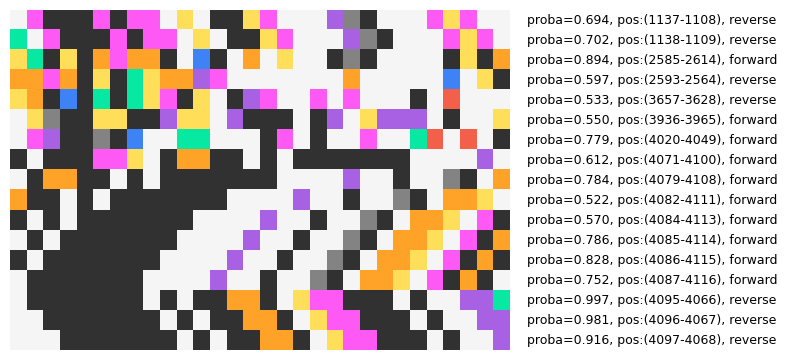

In [34]:
from pici_predictor.phrog_function import function_num_to_color
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Prepare your data as before
heatmap_data = np.array(pici_segments["function_vector"].tolist())
labels = [
    f"proba={row.predicted_prob:.3f}, pos:({row.start_idx}-{row.end_idx}), {'reverse' if not row.forward else 'forward'}"
    for _, row in pici_segments.iterrows()
]
function_nums_sorted = sorted(function_num_to_color.keys())
color_list = [function_num_to_color[num] for num in function_nums_sorted]
cmap = ListedColormap(color_list)
num_to_idx = {num: i for i, num in enumerate(function_nums_sorted)}
heatmap_indices = np.vectorize(num_to_idx.get)(heatmap_data)

# Plot
fig, ax = plt.subplots(figsize=(5, len(heatmap_indices) * 0.2))
im = ax.imshow(heatmap_indices, aspect="auto", cmap=cmap)

# Remove axes, ticks, and margins
ax.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Add labels as text
for i, label in enumerate(labels):
    ax.text(
        heatmap_indices.shape[1] + 0.5,  # x position (just to the right of the heatmap)
        i,  # y position (row)
        label,
        va="center",
        ha="left",
        fontsize=9,
        color="black",
    )

plt.savefig(
    "../results/demonstration/GCF_000175755.1/pici_segments_heatmap.png",
    bbox_inches="tight",
    pad_inches=0,
    dpi=300,
)
